In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.colors import TwoSlopeNorm


In [2]:
df = pd.read_csv('with LongLat_rainfall_trend_results.csv')

# Convert degrees and minutes to decimal degrees for latitude and longitude
df['latitude'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['longitude'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary
bd_gdf = gpd.read_file('geoBoundaries-BGD-ADM0_simplified.geojson')


In [3]:
#Prepare data for interpolation
x = df['longitude'].values
y = df['latitude'].values


IDW METHOD 

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      -0.59936]


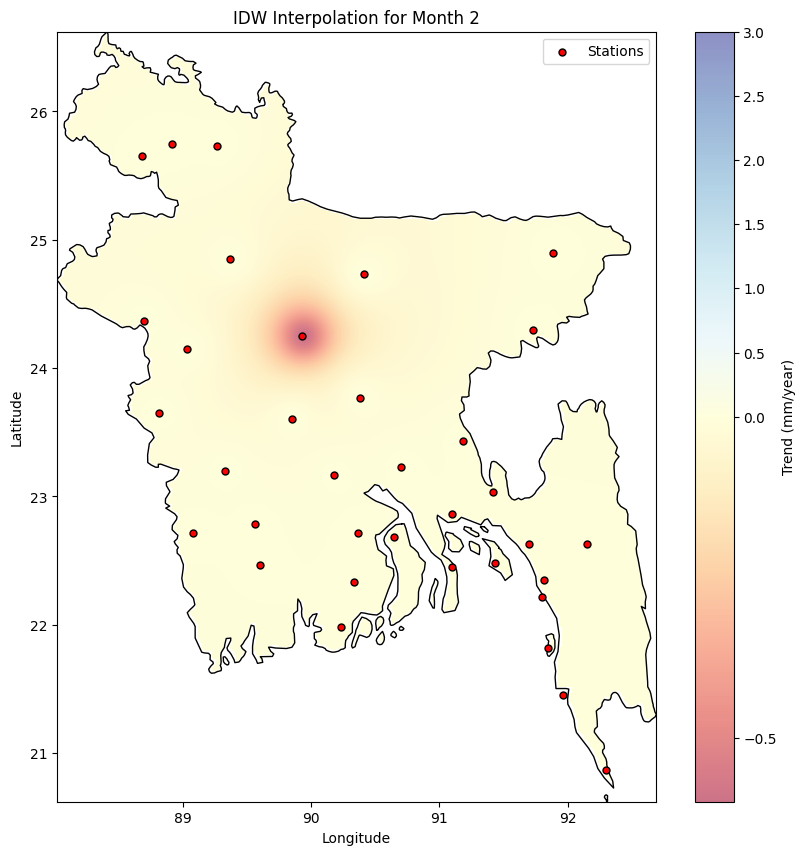

In [9]:
# Loop through each month
for p in range(2, 3):  # For months 1 to 12
    month_name = str(p)
    z = df[month_name].values  # Replace with the correct column for data
    
    print(z)
    
    # Create a grid for interpolation
    krig_bounds_xmin = bd_gdf.bounds.minx.iloc[0]
    krig_bounds_xmax = bd_gdf.bounds.maxx.iloc[0]
    krig_bounds_ymin = bd_gdf.bounds.miny.iloc[0]
    krig_bounds_ymax = bd_gdf.bounds.maxy.iloc[0]

    # Grid resolution
    horizontal_distance = krig_bounds_xmax - krig_bounds_xmin
    horizontal_resolution = 300  # Higher = more time/memory
    use_resolution = horizontal_distance / horizontal_resolution

    gridx = np.arange(krig_bounds_xmin, krig_bounds_xmax, use_resolution)
    gridy = np.arange(krig_bounds_ymin, krig_bounds_ymax, use_resolution)
    xx, yy = np.meshgrid(gridx, gridy)

    # IDW Function
    def idw_interpolation(x, y, z, gridx, gridy, power=2):
        """Perform Inverse Distance Weighting (IDW) interpolation."""
        interpolated = np.zeros_like(xx, dtype=float)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                distances = np.sqrt((x - xx[i, j]) ** 2 + (y - yy[i, j]) ** 2)
                weights = 1 / (distances ** power + 1e-10)  # Avoid division by zero
                interpolated[i, j] = np.sum(weights * z) / np.sum(weights)
        return interpolated

    # Apply IDW
    z_interp = idw_interpolation(x, y, z, gridx, gridy)

    # Mask the data outside the boundary
    points = [Point(px, py) for px, py in zip(xx.flatten(), yy.flatten())]
    mask = np.array([bd_gdf.contains(point).any() for point in points]).reshape(xx.shape)
    z_interp_masked = np.ma.masked_array(z_interp, mask=~mask)

    # Ensure vmin, vcenter, and vmax are in ascending order
    vmin = z_interp_masked.min()
    vmax = z_interp_masked.max()

    # Adjust vmin and vmax if needed
    if vmin >= 0:
        vmin = -0.1  # Ensure vmin is less than 0 for proper divergence
        vmin = -3  # Ensure vmin is less than 0 for proper divergence
    if vmax <= 0:
        vmax = 0.1  # Ensure vmax is greater than 0 for proper divergence
        vmax =3  # Ensure vmax is greater than 0 for proper divergence

    # Create the TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 10))
    bd_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    im = ax.imshow(
        z_interp_masked,
        extent=[krig_bounds_xmin, krig_bounds_xmax, krig_bounds_ymin, krig_bounds_ymax],
        origin='lower',
        cmap='RdYlBu',  # Diverging colormap (Red-Yellow-Blue)
        #alpha=0.7,
        alpha=0.55,
        norm=norm,  # Apply TwoSlopeNorm
    )
    plt.colorbar(im, ax=ax, label='Trend (mm/year)')
    ax.scatter(x, y, c='red', s=25, edgecolor='black', label='Stations')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IDW Interpolation for Month {month_name}')
    ax.legend()
    plt.show()


Another method


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import TwoSlopeNorm

In [52]:
from pykrige.ok import OrdinaryKriging  # Import Kriging

In [ ]:
from pykrige.ok import OrdinaryKriging  # Import Kriging

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.      -1.38462  0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.      -1.40741 -1.42105
 -1.02778  0.       0.     ]


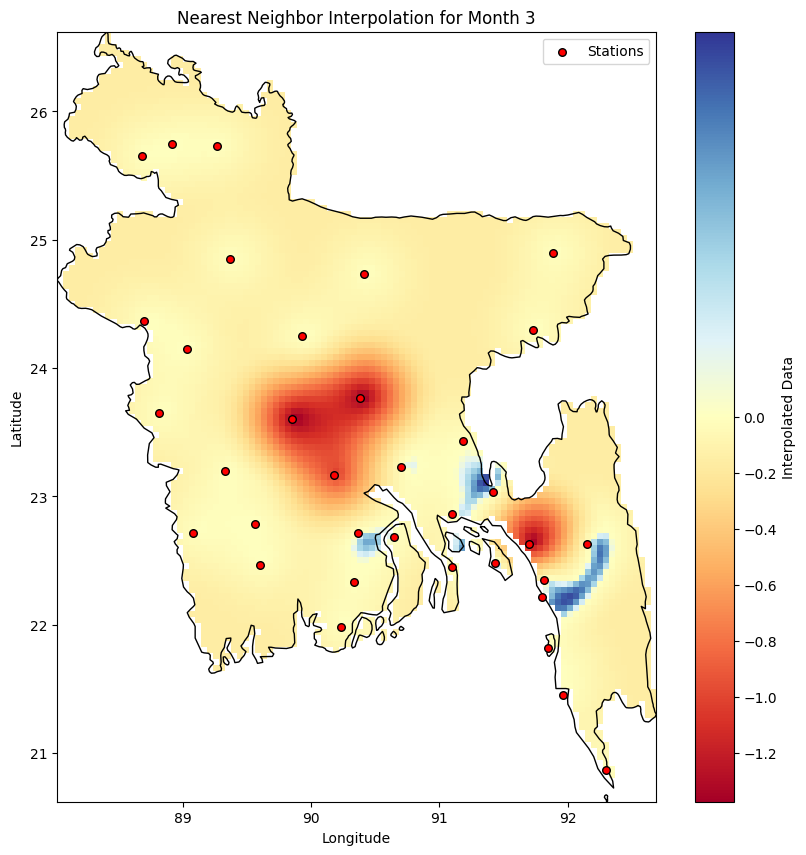

[ 0.       0.      -1.47619 -2.22581  0.       0.       0.      -3.64286
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.      -2.5      0.      -2.       0.
  0.       0.      -2.66667  0.       0.       0.       0.      -2.76923
 -2.40741  0.       0.     ]


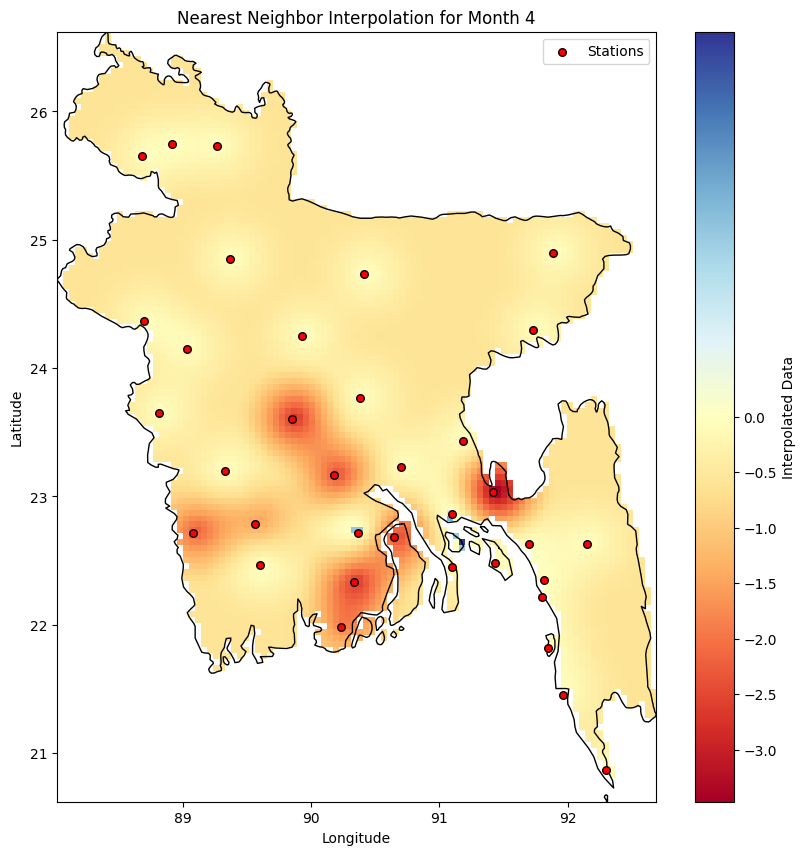

In [56]:
# Loop through selected months (e.g., 3 to 5)
for p in range(3, 5):  
    month_name = str(p)
    z = df[month_name].values  # Extract rainfall data for the month
    
    print(z)

    # Define grid boundaries
    krig_bounds_xmin = bd_gdf.bounds.minx.iloc[0]
    krig_bounds_xmax = bd_gdf.bounds.maxx.iloc[0]
    krig_bounds_ymin = bd_gdf.bounds.miny.iloc[0]
    krig_bounds_ymax = bd_gdf.bounds.maxy.iloc[0]

    # Grid resolution
    horizontal_distance = krig_bounds_xmax - krig_bounds_xmin
    horizontal_resolution = 100  
    use_resolution = horizontal_distance / horizontal_resolution

    gridx = np.arange(krig_bounds_xmin, krig_bounds_xmax, use_resolution)
    gridy = np.arange(krig_bounds_ymin, krig_bounds_ymax, use_resolution)
    xx, yy = np.meshgrid(gridx, gridy)

    # **Nearest Neighbor Interpolation**
    #z_interp = griddata((x, y), z, (xx, yy), method='linear')4
    OK = OrdinaryKriging(x, y, z, variogram_model="spherical", verbose=False, enable_plotting=False)
    z_interp, ss = OK.execute("grid", gridx, gridy)
    # **Mask the data outside the boundary**
    points = [Point(px, py) for px, py in zip(xx.flatten(), yy.flatten())]
    mask = np.array([bd_gdf.contains(point).any() for point in points]).reshape(xx.shape)
    z_interp_masked = np.ma.masked_array(z_interp, mask=~mask)

    # **Ensure vmin, vcenter, and vmax are in ascending order**
    vmin = z_interp_masked.min()
    vmax = z_interp_masked.max()
    
    if vmin >= 0:
        vmin = -0.1  
    if vmax <= 0:
        vmax = 0.1  

    # Apply TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # **Plot the results**
    fig, ax = plt.subplots(figsize=(10, 10))
    bd_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    im = ax.imshow(
        z_interp_masked,
        extent=[krig_bounds_xmin, krig_bounds_xmax, krig_bounds_ymin, krig_bounds_ymax],
        origin='lower',
        cmap='RdYlBu',  
        #alpha=0.5,
        alpha = 1,
        norm=norm,  
    )
    
    plt.colorbar(im, ax=ax, label='Interpolated Data')
    ax.scatter(x, y, c='red', s=30, edgecolor='black', label='Stations')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Nearest Neighbor Interpolation for Month {month_name}')
    ax.legend()
    plt.show()


Natural Neighbour


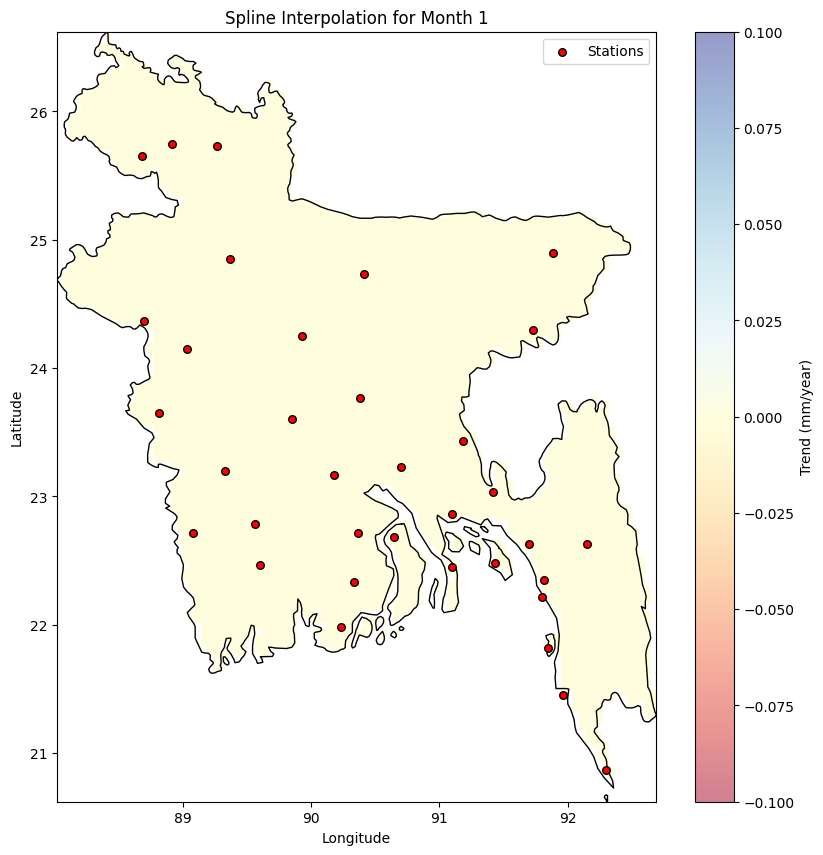

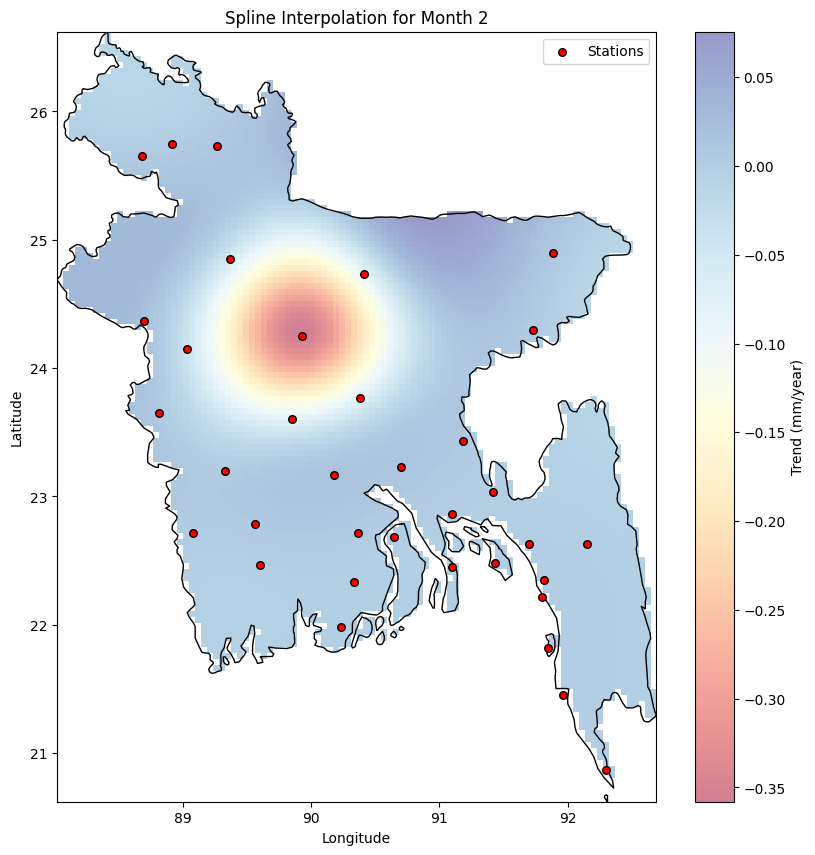

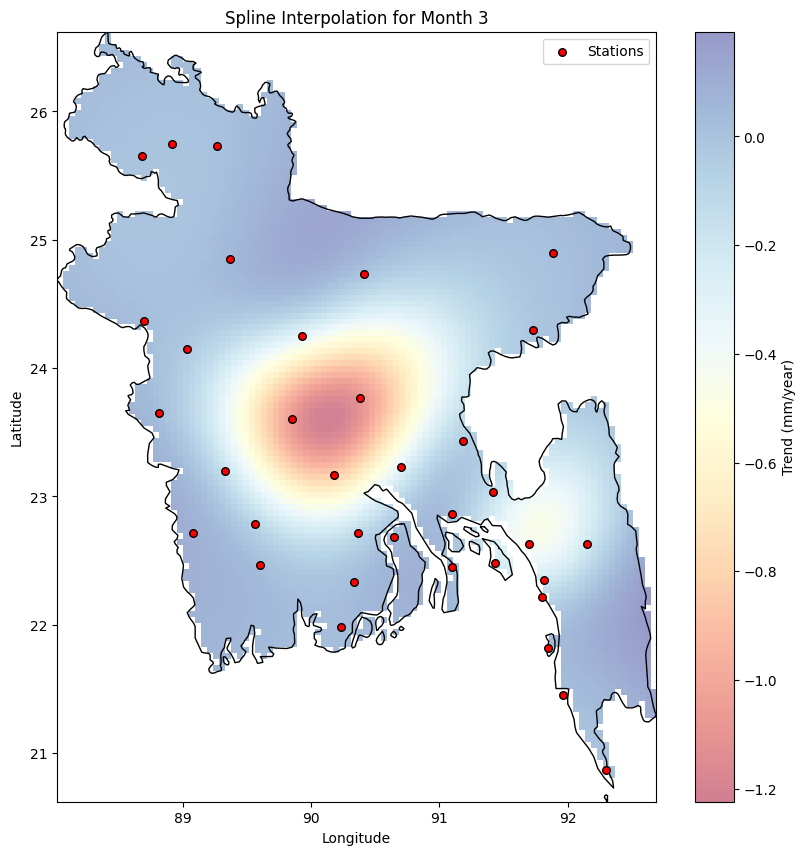

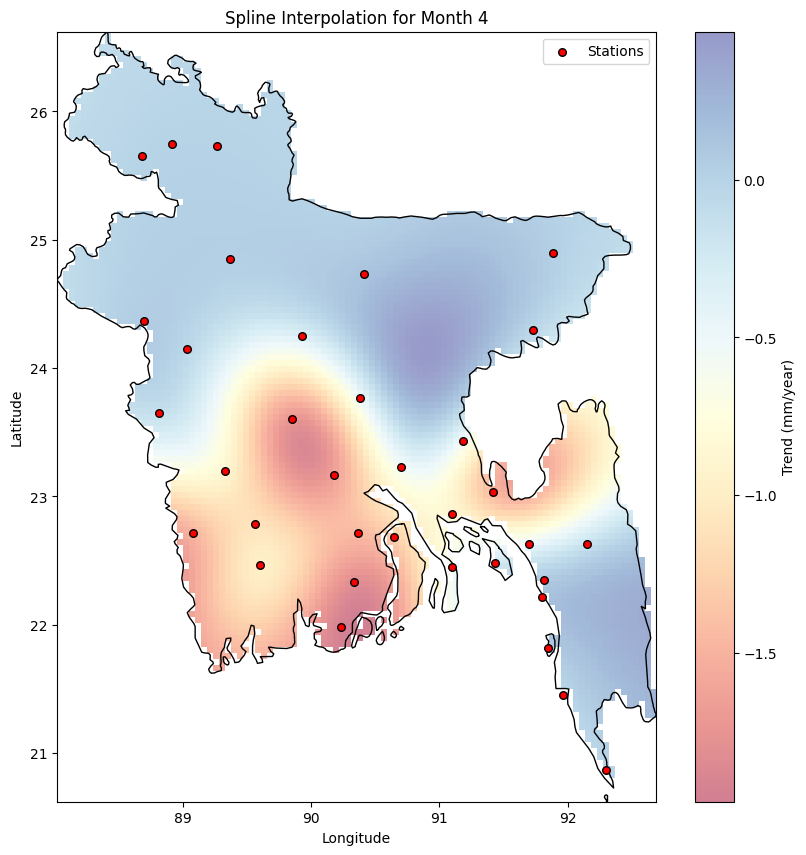

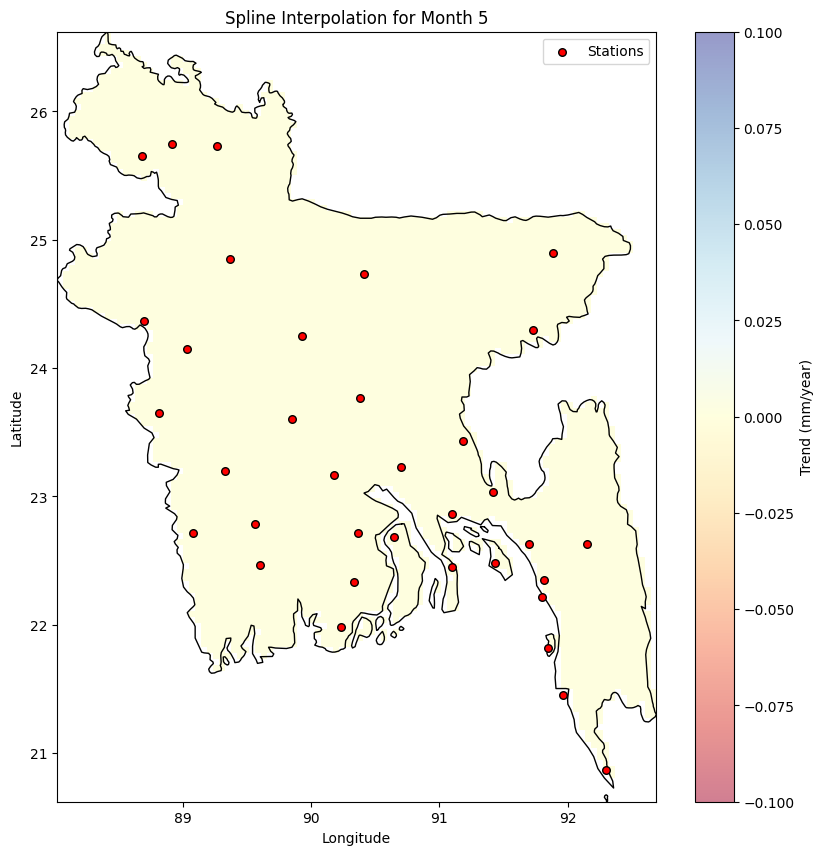

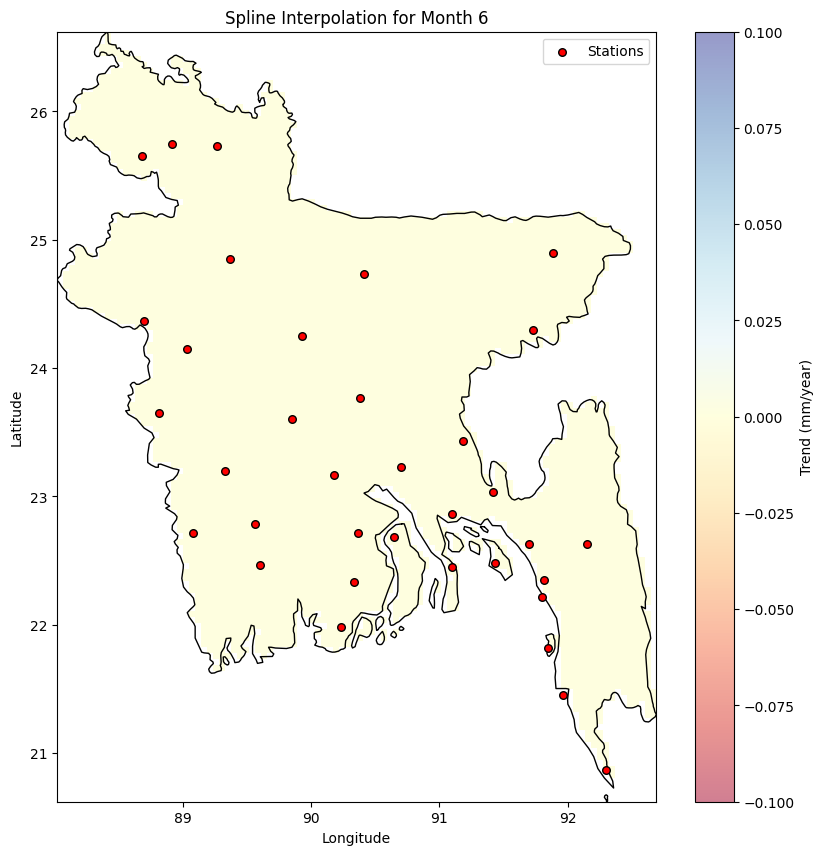

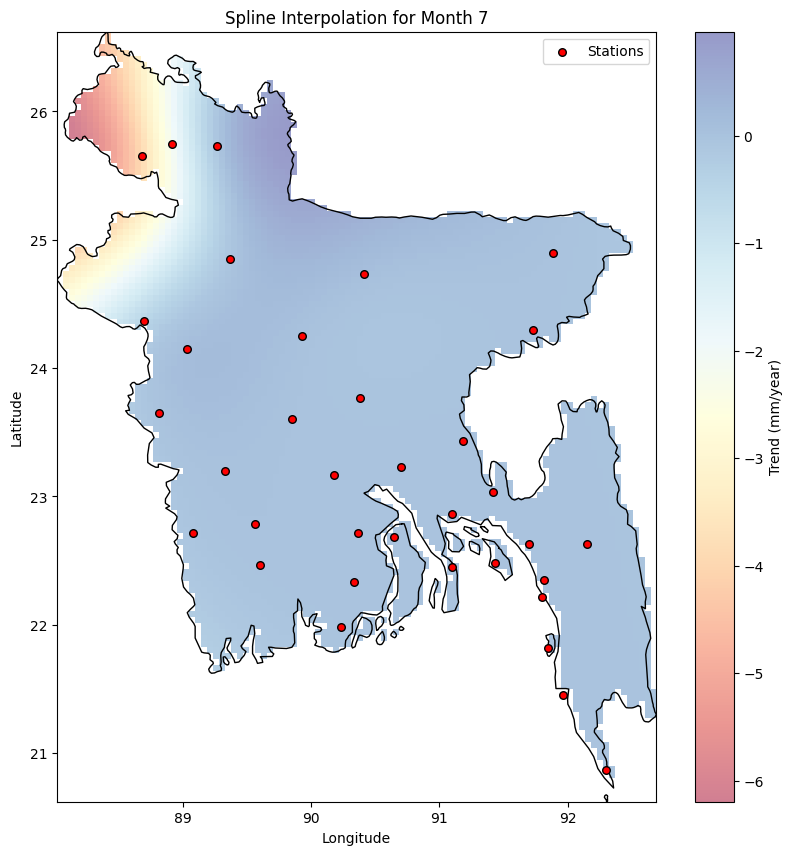

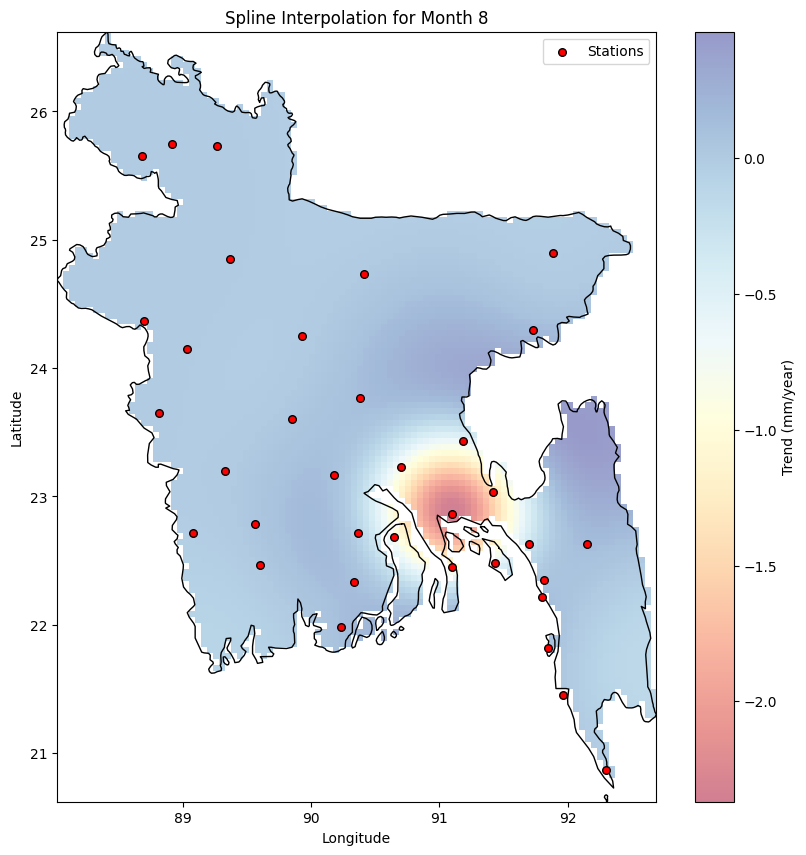

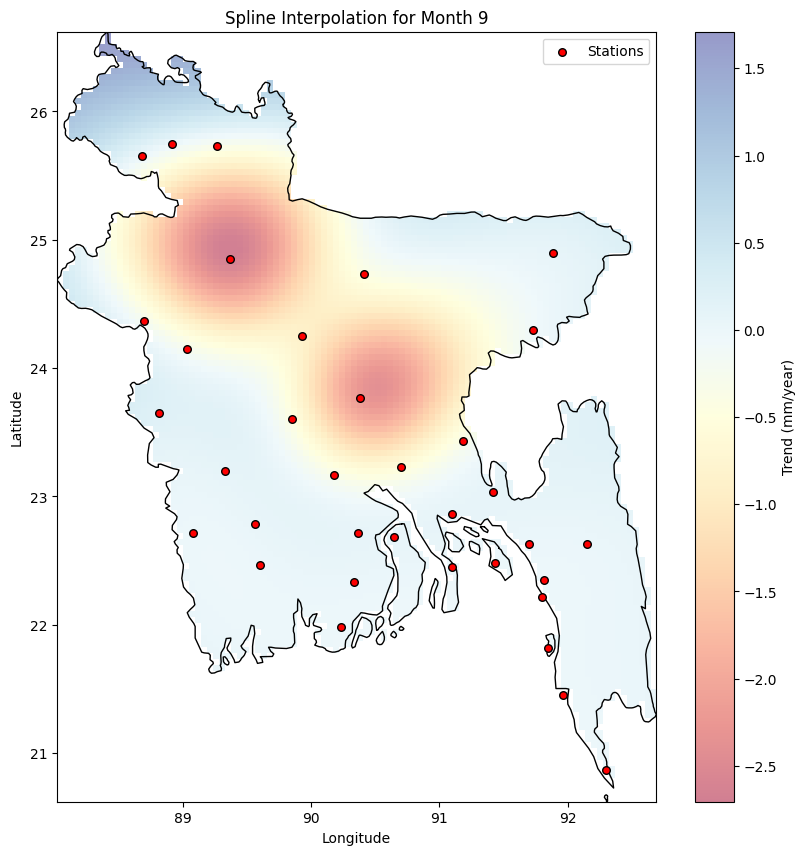

KeyboardInterrupt: 

In [72]:
from scipy.interpolate import Rbf

def spline_interpolation(x, y, z, gridx, gridy):
    # Use Radial Basis Function (RBF) interpolation with a smooth transition
    rbf = Rbf(x, y, z, function='multiquadric', smooth=0.1)  # 'smooth' controls the smoothness
    z_interp = rbf(gridx, gridy)

    return z_interp

# Loop through each month
for p in range(1, 13):  # For months 1 to 12
    month_name = str(p)
    z = df[month_name].values  # Replace with the correct column for data

    # Create a grid for interpolation
    krig_bounds_xmin = bd_gdf.bounds.minx.iloc[0]
    krig_bounds_xmax = bd_gdf.bounds.maxx.iloc[0]
    krig_bounds_ymin = bd_gdf.bounds.miny.iloc[0]
    krig_bounds_ymax = bd_gdf.bounds.maxy.iloc[0]

    # Grid resolution
    horizontal_distance = krig_bounds_xmax - krig_bounds_xmin
    horizontal_resolution = 100  # Higher = more time/memory
    use_resolution = horizontal_distance / horizontal_resolution

    gridx = np.arange(krig_bounds_xmin, krig_bounds_xmax, use_resolution)
    gridy = np.arange(krig_bounds_ymin, krig_bounds_ymax, use_resolution)
    xx, yy = np.meshgrid(gridx, gridy)

    # Apply Spline Interpolation
    z_interp = spline_interpolation(x, y, z, xx, yy)

    # Mask the data outside the boundary
    points = [Point(px, py) for px, py in zip(xx.flatten(), yy.flatten())]
    mask = np.array([bd_gdf.contains(point).any() for point in points]).reshape(xx.shape)
    z_interp_masked = np.ma.masked_array(z_interp, mask=~mask)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 10))
    bd_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    im = ax.imshow(
        z_interp_masked,
        extent=[krig_bounds_xmin, krig_bounds_xmax, krig_bounds_ymin, krig_bounds_ymax],
        origin='lower',
        cmap='RdYlBu',  # Diverging colormap (Red-Yellow-Blue)
        alpha=0.5,
    )
    plt.colorbar(im, ax=ax, label='Trend (mm/year)')
    ax.scatter(x, y, c='red', s=30, edgecolor='black', label='Stations')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Spline Interpolation for Month {month_name}')
    ax.legend()
    plt.show()


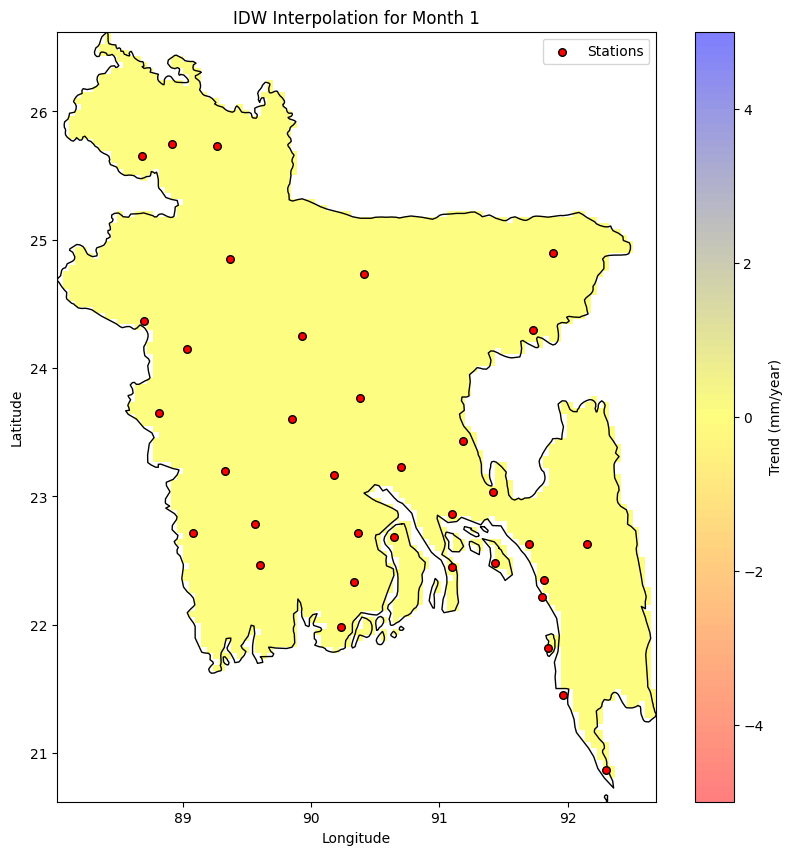

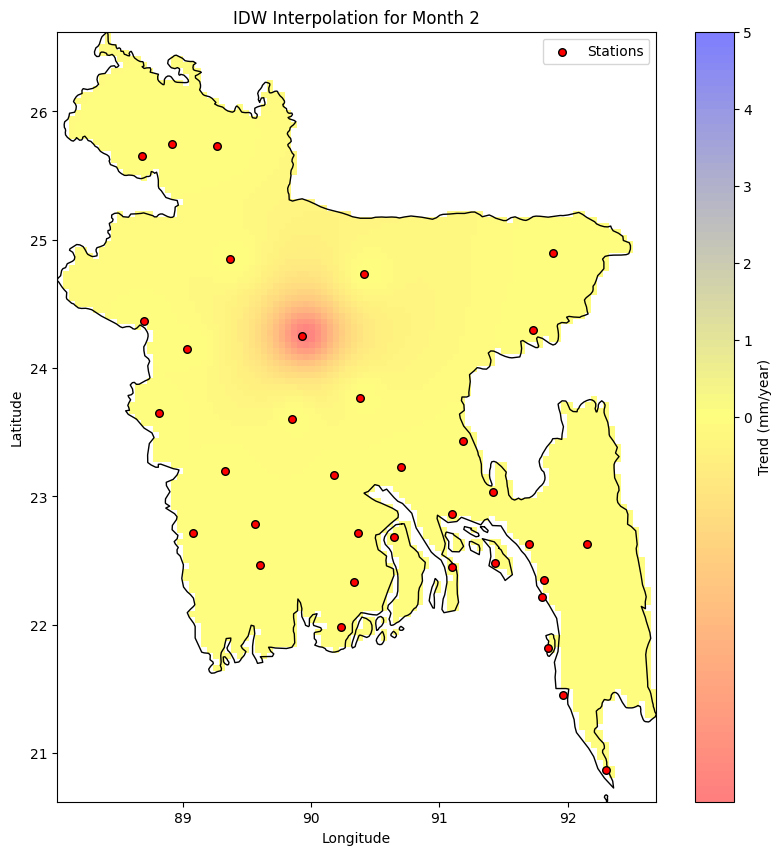

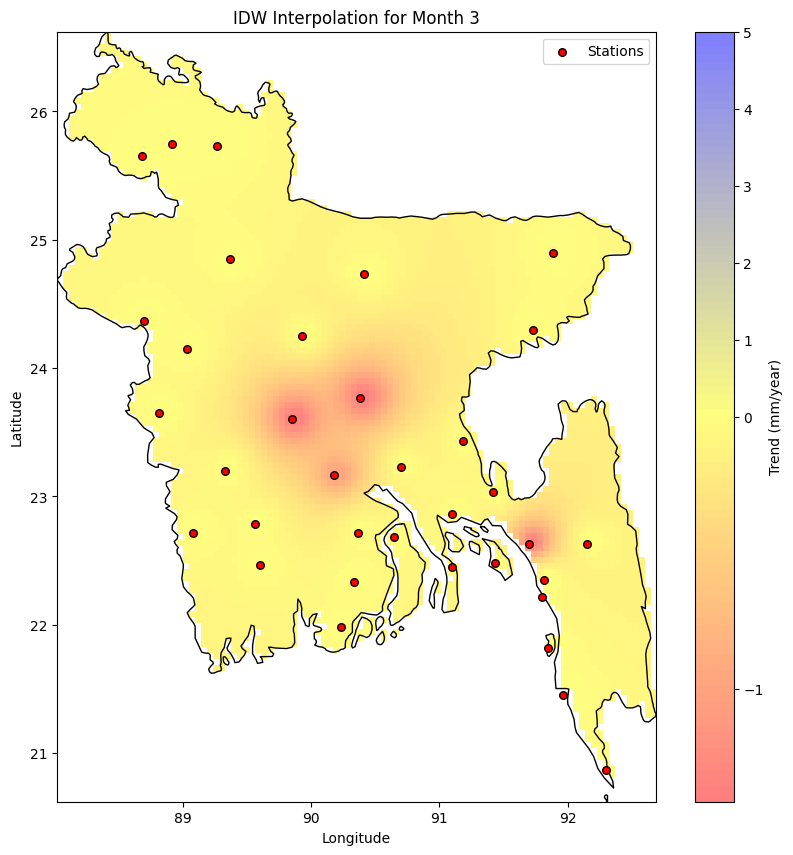

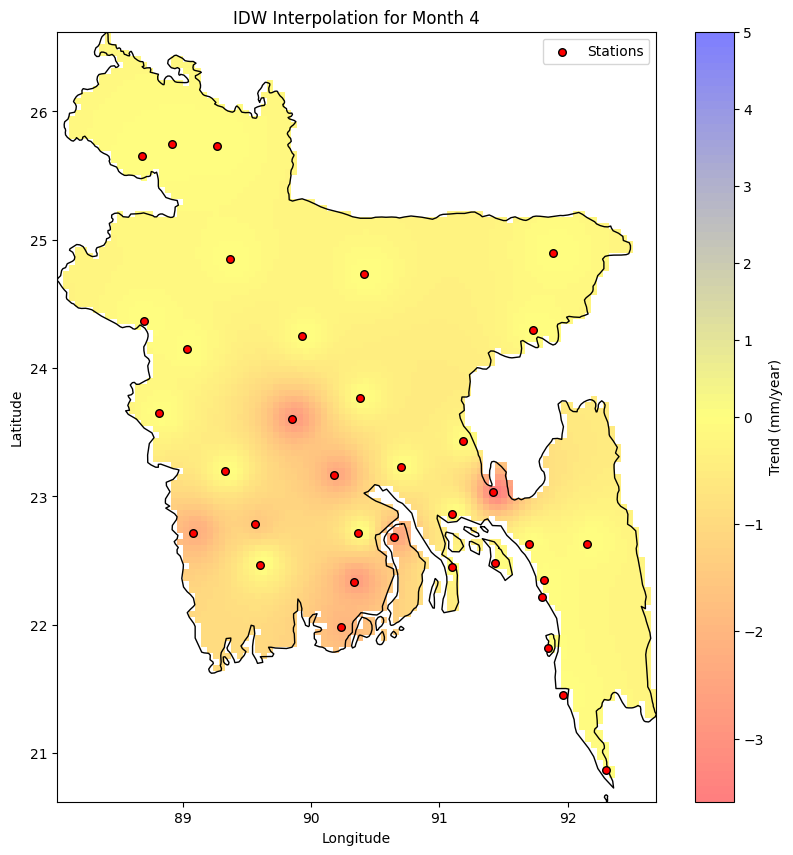

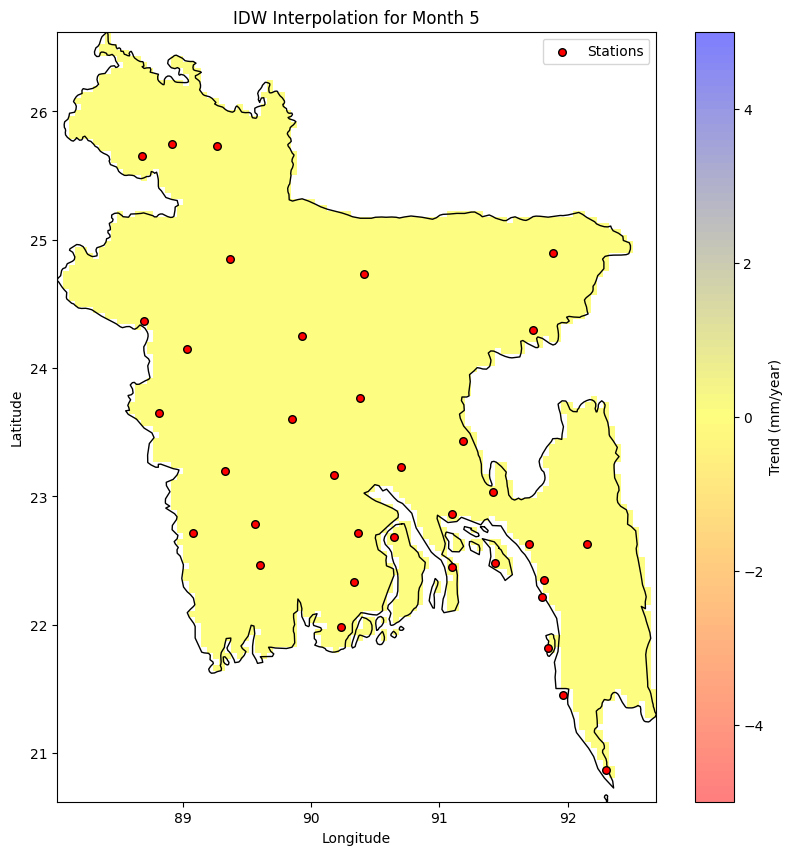

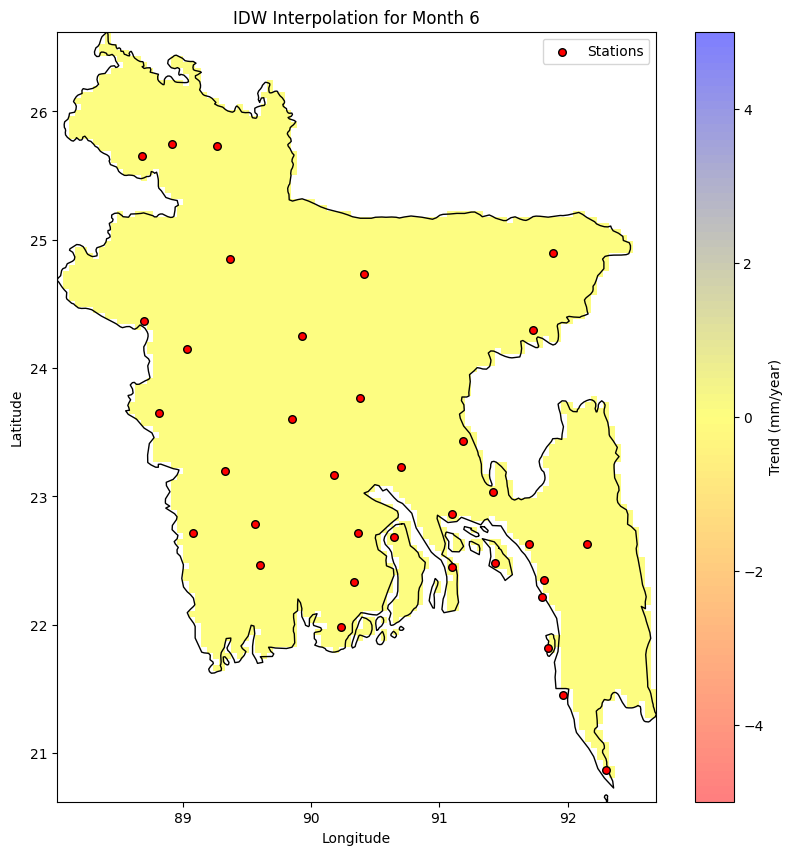

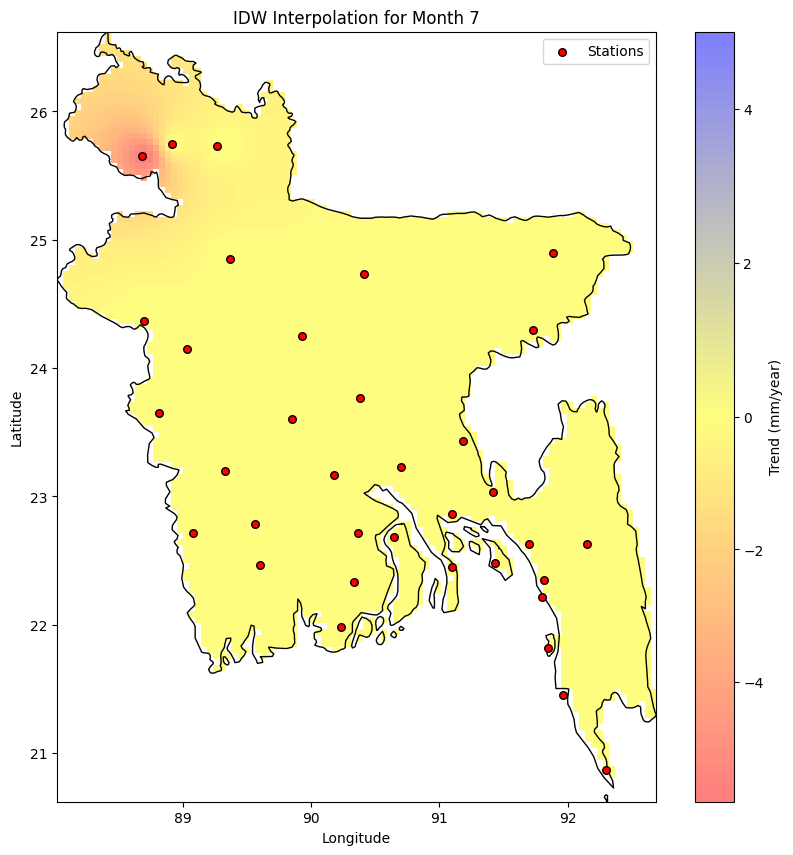

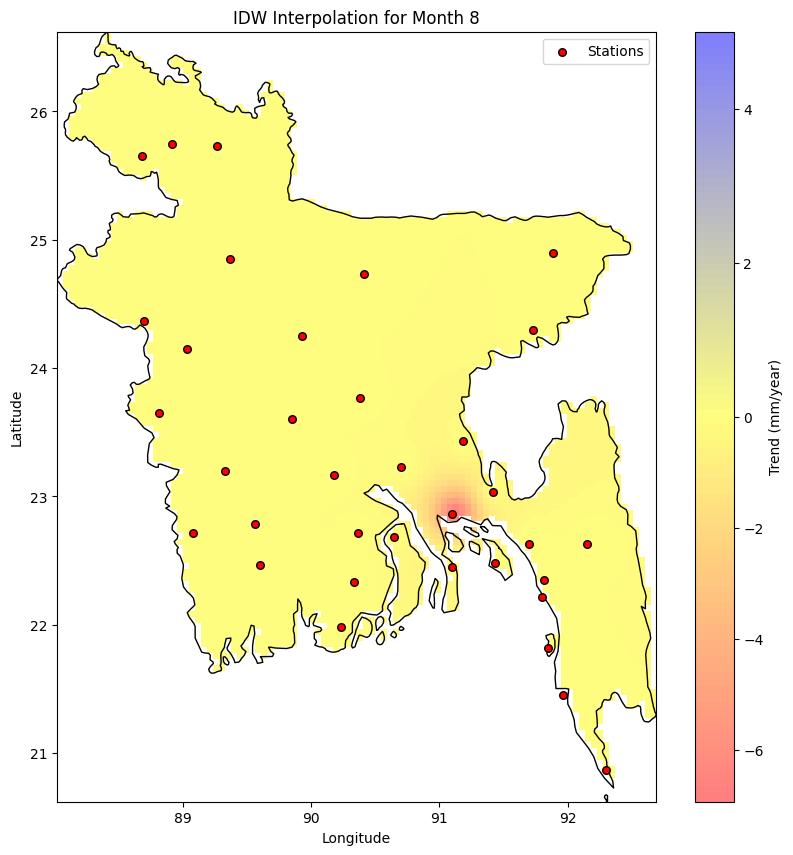

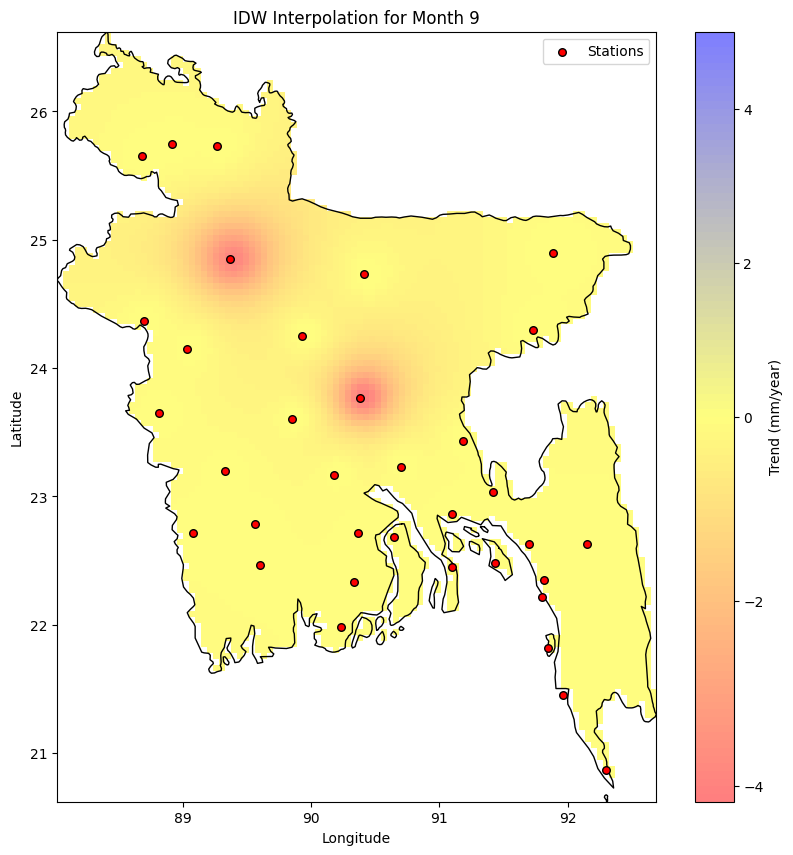

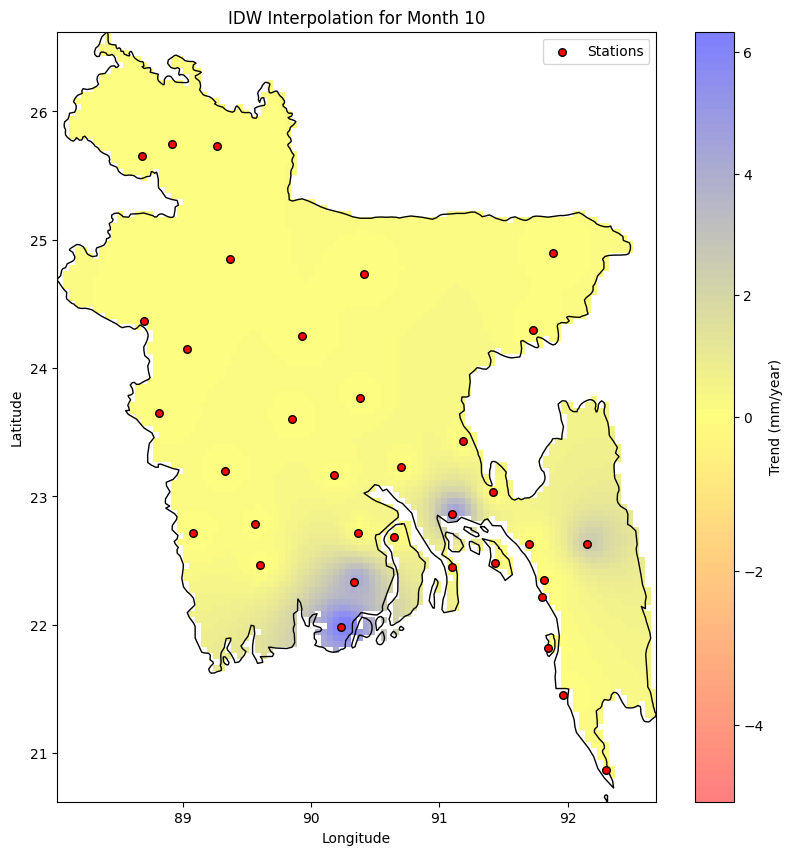

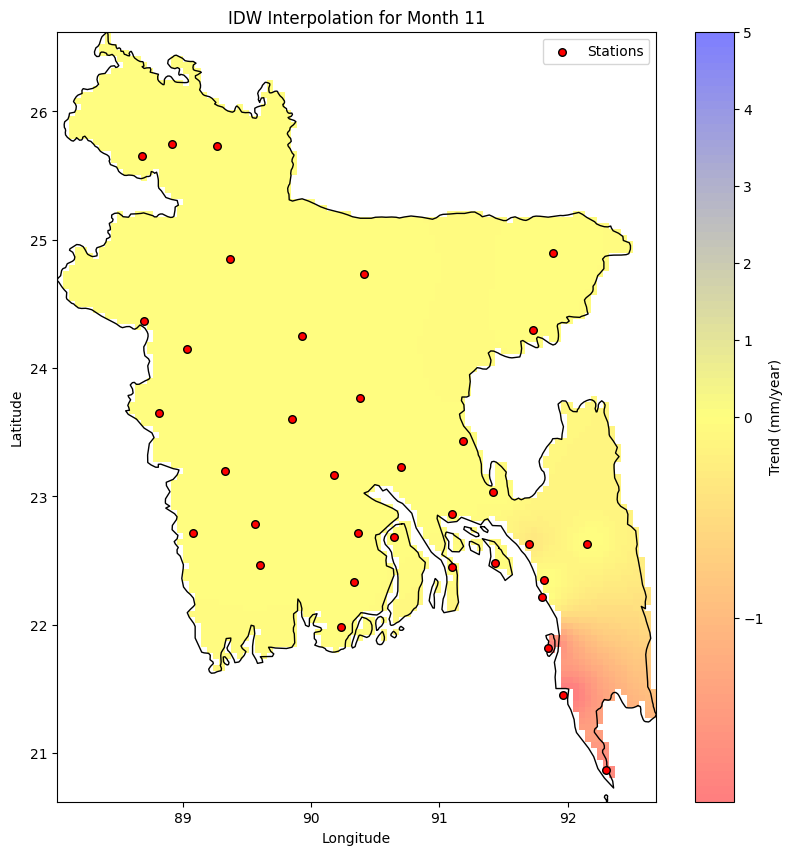

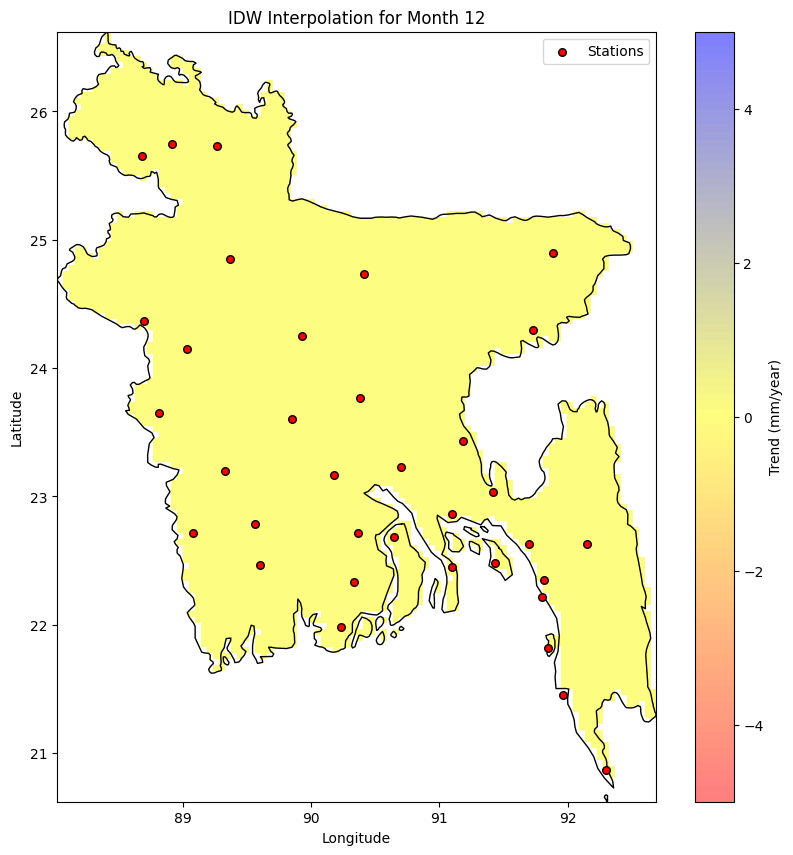

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from shapely.geometry import Point

# Define custom colormap with red, yellow, and blue
colors = [(1, 0, 0), (1, 1, 0), (0, 0, 1)]  # Red -> Yellow -> Blue
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'red_yellow_blue'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Loop through each month
for p in range(1, 13):  # For months 1 to 12
    month_name = str(p)
    z = df[month_name].values  # Replace with the correct column for data
    
    # Create a grid for interpolation
    krig_bounds_xmin = bd_gdf.bounds.minx.iloc[0]
    krig_bounds_xmax = bd_gdf.bounds.maxx.iloc[0]
    krig_bounds_ymin = bd_gdf.bounds.miny.iloc[0]
    krig_bounds_ymax = bd_gdf.bounds.maxy.iloc[0]

    # Grid resolution
    horizontal_distance = krig_bounds_xmax - krig_bounds_xmin
    horizontal_resolution = 100  # Higher = more time/memory
    use_resolution = horizontal_distance / horizontal_resolution

    gridx = np.arange(krig_bounds_xmin, krig_bounds_xmax, use_resolution)
    gridy = np.arange(krig_bounds_ymin, krig_bounds_ymax, use_resolution)
    xx, yy = np.meshgrid(gridx, gridy)

    # IDW Function
    def idw_interpolation(x, y, z, gridx, gridy, power=2):
        """Perform Inverse Distance Weighting (IDW) interpolation."""
        interpolated = np.zeros_like(xx, dtype=float)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                distances = np.sqrt((x - xx[i, j]) ** 2 + (y - yy[i, j]) ** 2)
                weights = 1 / (distances ** power + 1e-10)  # Avoid division by zero
                interpolated[i, j] = np.sum(weights * z) / np.sum(weights)
        return interpolated

    # Apply IDW
    z_interp = idw_interpolation(x, y, z, gridx, gridy)

    # Mask the data outside the boundary
    points = [Point(px, py) for px, py in zip(xx.flatten(), yy.flatten())]
    mask = np.array([bd_gdf.contains(point).any() for point in points]).reshape(xx.shape)
    z_interp_masked = np.ma.masked_array(z_interp, mask=~mask)

    # Ensure vmin, vcenter, and vmax are in ascending order
    vmin = z_interp_masked.min()
    vmax = z_interp_masked.max()

    # Adjust vmin and vmax if needed
    if vmin >= 0:
        vmin = -5  # Ensure vmin is less than 0 for proper divergence
    if vmax <= 0:
        vmax = 5  # Ensure vmax is greater than 0 for proper divergence

    # Create the TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 10))
    bd_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    im = ax.imshow(
        z_interp_masked,
        extent=[krig_bounds_xmin, krig_bounds_xmax, krig_bounds_ymin, krig_bounds_ymax],
        origin='lower',
        cmap=custom_cmap,  # Use the custom colormap
        alpha=0.5,
        norm=norm,  # Apply TwoSlopeNorm
    )
    plt.colorbar(im, ax=ax, label='Trend (mm/year)')
    ax.scatter(x, y, c='red', s=30, edgecolor='black', label='Stations')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IDW Interpolation for Month {month_name}')
    ax.legend()
    plt.show()
